### Importing some libraries and the file of the real calib data ###

In [1]:
## Import Libraries
import h5py # library to read and write HDF5 files
import matplotlib
import matplotlib.pyplot as plt # data visualisation
import numpy as np # for numerical operations on arrays and matrices
import awkward as ak # for handling complex, hierarchical data (common in HEP). 
import glob # used for file pattern matching
import os

from types import FunctionType
import tqdm
import functions

# Legend-exp specific libraries
from legendmeta import LegendMetadata
from lgdo import lh5 # for handling and processing LH5 data formats
import pygama
from pygama.pargen.data_cleaning import get_tcm_pulser_ids
from pygama import logging
logging.setup(level=logging.INFO)  # or e.g. logging.DEBUG (noisy!)


## Define environmental variables
# magic command that sets an environment variable: 
# disables file locking for HDF5 files, which can be necessary in some parallel computing environments where file locking causes issues.
# IMPORTANT NOTE: REQUIRES RUNNING ON A GPU NODE; DOES NOT WORK ON LOGIN NODES (there will be HDF5 File closing issues)
%env HDF5_USE_FILE_LOCKING=FALSE
%matplotlib inline


env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
# SSH authentification for LegendMetadata
os.environ["SSH_AUTH_SOCK"] = "/tmp/ssh-UBVjTAJuSLq5/agent.97029"

In [3]:
lmeta = LegendMetadata()
#lmeta.channelmap()['V02160A'] # Detector V02160A has raw-id 1104000

Cloning git@github.com:legend-exp/legend-metadata in /tmp/legend-metadata-gsenator...


In [4]:
# Define custom colors (replace with actual color values you want to use)
cset = {
    'grey': '#7F7F7F',  # Example grey color
    'blue': '#1F77B4',  # Example blue color
    'red': '#D62728'    # Example red color
}

# Update matplotlib parameters for consistent styling
plt.rc("axes", prop_cycle=plt.cycler('color', [cset['grey'], cset['grey'], cset['blue'], cset['red']]))
plt.rcParams.update({
    "figure.figsize": (28, 10),
    "lines.linewidth": 1,
    "image.cmap": "magma"
})
plt.rcParams.update({'font.size': 22})

In [5]:
files = []
files_tcm = []
RUNS = ['/*.lh5']
files_tcm.append(functions.load_filenames('/global/cfs/projectdirs/legend/data/lngs/l200/public/prodenv/prod-blind/ref-v1.0.0/generated/tier/tcm/cal/p04/r001', RUNS)) #pht data #files_lh5 #/global/cfs/projectdirs/legend/data/lngs/l200/public/prodenv/prod-blind/ref-v1.0.0/generated/tier/pht/cal/p04/r001
files.append(functions.load_filenames('files_lh5', RUNS))

In [12]:
import datetime
date1 = datetime.datetime.strptime('13:18:17', '%H:%M:%S')
date2 = datetime.datetime.strptime('15:21:04', '%H:%M:%S')
time_diff = date2 - date1
seconds = time_diff.total_seconds()
print(f"Seconds: {seconds}")

Seconds: 7367.0


In [ ]:
weights = {}

with h5py.File(files[0][0][0], "r") as f:
    print("Keys: %s" % f.keys())
    channels = list(f.keys())[0]
    cuts = list(f[channels]['hit'].keys())
    values = f[channels]['hit']['AoE_Classifier'][()]
    
    for i in range (len(cuts)):
        weights[cuts[i]] = f[channels]['hit'][cuts[i]][()]
print(cuts)
print(weights['AoE_Classifier'])
print(weights['AoE_Corrected'])
print(weights['is_valid_cal'])

In [ ]:
lh5.tools.show(files_tcm[0][0][0], attrs=True, detail=True)

##  Considering all 89 detectors ##

In [6]:
with h5py.File(files[0][0][0], "r") as f:
    print("Keys: %s" % f.keys())
    channels = list(f.keys())

Keys: <KeysViewHDF5 ['ch1078400', 'ch1078405', 'ch1080000', 'ch1080001', 'ch1080004', 'ch1080005', 'ch1081600', 'ch1081601', 'ch1081602', 'ch1081603', 'ch1081604', 'ch1081605', 'ch1083201', 'ch1083202', 'ch1083203', 'ch1083204', 'ch1083205', 'ch1084800', 'ch1084801', 'ch1084802', 'ch1084803', 'ch1084804', 'ch1084805', 'ch1086400', 'ch1086401', 'ch1086403', 'ch1086404', 'ch1086405', 'ch1088001', 'ch1088002', 'ch1088003', 'ch1089600', 'ch1089601', 'ch1089603', 'ch1104000', 'ch1104001', 'ch1104002', 'ch1104003', 'ch1104004', 'ch1104005', 'ch1105600', 'ch1105602', 'ch1105603', 'ch1107202', 'ch1107203', 'ch1107204', 'ch1107205', 'ch1108800', 'ch1108801', 'ch1108802', 'ch1108803', 'ch1110402', 'ch1110403', 'ch1110404', 'ch1112000', 'ch1112001', 'ch1112002', 'ch1112003', 'ch1112004', 'ch1112005', 'ch1113600', 'ch1113601', 'ch1113602', 'ch1113603', 'ch1113604', 'ch1113605', 'ch1115203', 'ch1115204', 'ch1116801', 'ch1116802', 'ch1116803', 'ch1116804', 'ch1116805', 'ch1118402', 'ch1118403', 'ch1

In [24]:
#Function to remove the pulsers from the real data
def remove_pulser(tcm_path, channel_id, multiplicity, data_inject):
    ids, mask_pulser = get_tcm_pulser_ids(tcm_path, channel_id, multiplicity)
    #mask_pulser = [int(b) for b in mask_pulser]
    data_nopulser = data_inject[~mask_pulser]
    return data_nopulser

In [26]:
## Import data: PHT
num_evt_tot = 0
energies_all_detectors = []
for ch in channels:
    pht_data = lh5.read_as(
        ch+'/hit',
        files[0][0][0:29], #files[0][0][0:29],
        library="ak" #data should be read into the awkward array format 
    )
    
    data_no_pulser = remove_pulser(files_tcm[0][0][0:29], int(ch[2:]), 5, pht_data)
    data_no_pulser_clean = data_no_pulser[(data_no_pulser.zacEmax_cal < 4000) & (data_no_pulser.zacEmax_cal > 0) & (data_no_pulser.is_valid_cal == 1)]
    energies_all_detectors.append(data_no_pulser_clean.zacEmax_cal)
    num_evt_tot += len(pht_data)

In [28]:
num_evt_tot

28016806

In [29]:
len(energies_all_detectors)

89

In [30]:
energies_all_detectors_flat = [
    x
    for xs in energies_all_detectors
    for x in xs
]

In [31]:
len(energies_all_detectors_flat)

24998539

In [32]:
my_file = open("real_data_all_detectors_no_pulses_clean_29_october.txt", "w")
for i in range (len(energies_all_detectors_flat)):
    my_file.write(str(energies_all_detectors_flat[i]) + "\n")
    #print(str(bins[i]) + "\t" + str(hist_data[0][i]))
my_file.close()

In [44]:
def open_file(filename):
    my_file = open(filename, "r")
    lines = my_file.readlines()
    data = [float(e.strip()) for e in lines]
    my_file.close()
    return data

In [65]:
mage_bin[:4001]

array([   0,    1,    2, ..., 3998, 3999, 4000])

In [19]:
#energies_all_detectors_flat = open_file("real_data_all_detectors_no_pulses_clean_29_october.txt")

In [69]:
#Sources activities
activities = open_file("activities.txt")
time = 120*60 #time of the calibration [s]

In [75]:
#Import data simulated with MaGe:
RUNS = ['/*.txt']
mage_files = []
mage_files.append(functions.load_filenames('MaGe_data', RUNS))

mage_bin_content = np.zeros(shape=6000)
for j in range(len(mage_files[0][0])):
    mage_energies = open_file(mage_files[0][0][j])
    for i in range(len(mage_bin_content)):
        mage_bin_content[i] += mage_energies[i]*activities[j]*120*60
        
mage_bin_content = mage_bin_content/40E6
mage_bin = np.arange(0, 6001, 1)

In [82]:
my_file = open("mage_data_30_october.txt", "w")
for i in range (len(mage_bin_content)):
    my_file.write(str(mage_bin_content[i]) + "\n")
    #print(str(bins[i]) + "\t" + str(hist_data[0][i]))
my_file.close()

In [35]:
#Correcting the scaling time removing the time corresponded to the events filtered out
time = 120*60
scaling_time = time-((num_evt_tot-len(energies_all_detectors_flat))*130E-6)
print("Raw_time = " + str(time))
print("Scaling_time = " + str(scaling_time))
time = scaling_time

Raw_time = 7200
Scaling_time = 6807.62529


In [36]:
sum(activities)*time #Number of primaries expected in total from the 12 sources

150275414.48361486

In [37]:
def rescaling_histo(data, activity, time, bins):
    (counts, bins) = np.histogram(data, bins=bins, range=(0, 4000)) #, density=True)
    counts = counts*activity*time
    return counts, bins

In [78]:
counts_sim = np.zeros(shape=4000)
k = 0
sum_data_sim_tot = 0
for i in range(1,4):
    for j in range(1,5):
        data_sim = open_file(f"file_output_energies/file_output_energies_5M/simulation_data_source_{i}_{j}.txt")
        counts, bins = rescaling_histo(data_sim, activities[k], time, 4000)
        sum_data_sim_tot += len(data_sim)
        counts_sim += counts
        k += 1
        
counts_sim = counts_sim/5E6

In [39]:
sum_data_sim_tot #Number of data from the simulation

26966684

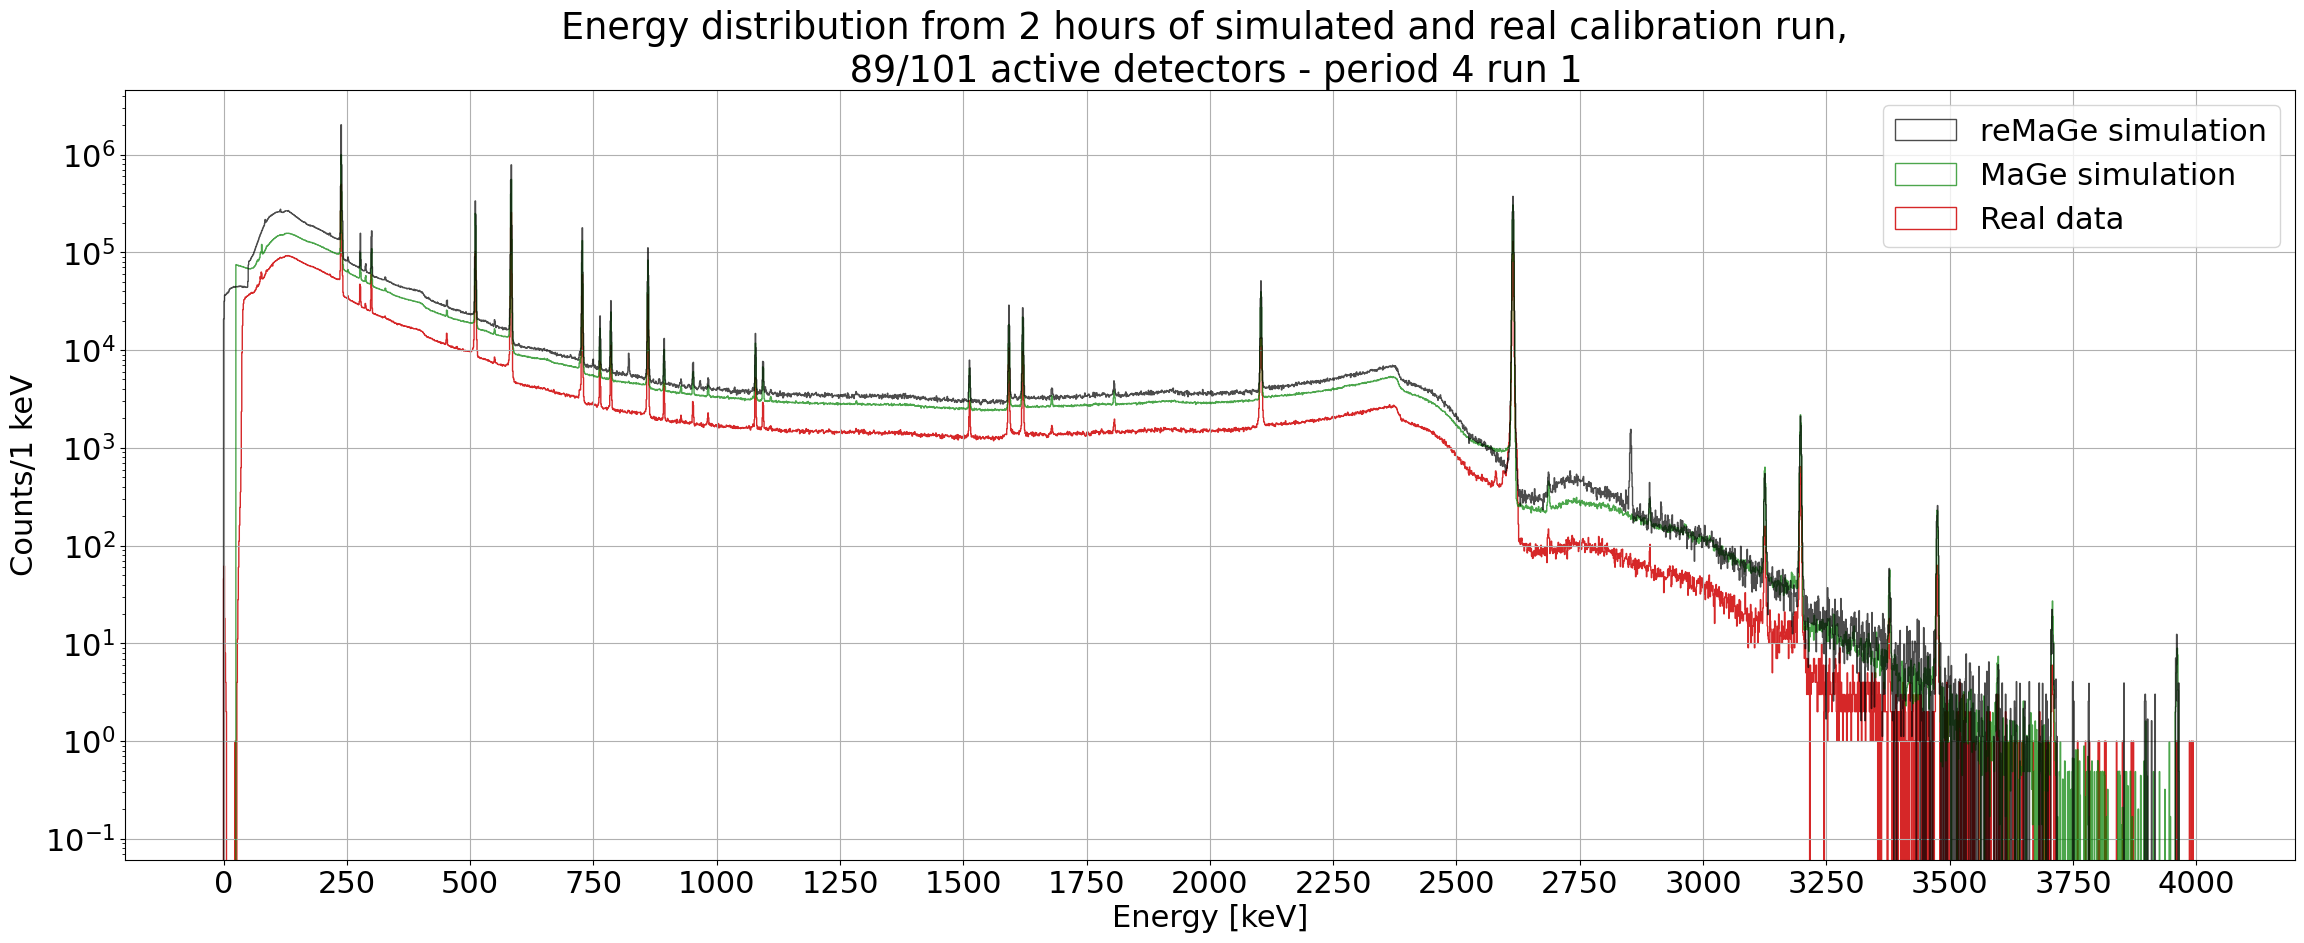

In [83]:
_, ax = plt.subplots()
hist_sim = ax.hist(bins[:-1], bins, weights=counts_sim, label='reMaGe simulation', range=[0, 4000], color='black', alpha=0.7, histtype='step', zorder=10)
hist_mage = ax.hist(mage_bin[:4000], mage_bin[:4001], weights=mage_bin_content[:4000], label='MaGe simulation', range=[0, 4000], color='green', alpha=0.7, histtype='step', zorder=5)
hist_data = ax.hist(energies_all_detectors_flat, bins=4000, label='Real data', range=[0, 4000], color='C3', histtype='step', zorder=0)
plt.legend()
plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel('Counts/1 keV')
#plt.xlim(2700, 3300)
plt.xticks(np.arange(0, 4250, 250))
plt.title(f'Energy distribution from 2 hours of simulated and real calibration run, \n 89/101 active detectors - period 4 run 1')
plt.grid()
plt.savefig('sim_mage+remage_vs_real_cal_all_detectors_30_october.png', bbox_inches='tight')
plt.show()

In [49]:
hist_sim[0][max_bin_plus_1-1]

209.20252672582865

In [54]:
#Pearson's chi-squared test
chi2_num = 0.
for i in range (10, max_bin_plus_1):
    #if hist_sim[0][i] != 0:
    chi2_num += (hist_sim[0][i] - hist_data[0][i])**2 / hist_data[0][i]
    
ndof = max_bin_plus_1-1.
chi2_ndof = chi2_num/ndof
print("Chi2 = " + str(chi2_num) + "; Chi2/ndof = " + str(chi2_ndof))

Chi2 = 2133998.5745556876; Chi2/ndof = 3334.372772743262


In [55]:
from scipy.stats import chi2
p_value = 1. - chi2.cdf(chi2_num, ndof)
print("p-value = " + str(p_value))

p-value = 0.0


## Now looking at individual detectors ##

In [44]:
#Now I look at individual detectors
bege = 1113601 #B00061A
icpc = 1116802 #V08682A
ppc = 1081601 #P00662C
Coax = 1120005 #C00ANG4

### BeGe ###

In [13]:
data = []
pht_data = lh5.read_as(
    'ch1113601/hit',
    files[0][0][0:29],
    library="ak" #data should be read into the awkward array format 
)

data.append(pht_data.zacEmax_cal)
data_no_pulser = remove_pulser(files_tcm[0][0][0:29], 1113601, 5, pht_data) #data[0])
data_no_pulser_clean = data_no_pulser[(data_no_pulser.zacEmax_cal < 4000) & (data_no_pulser.zacEmax_cal > 0) & (data_no_pulser.is_valid_cal == 1)]

In [14]:
len(data[0]) #Number of data in the real calibration run from that individual detector

520758

In [15]:
len(data_no_pulser)

517665

In [16]:
len(data_no_pulser_clean)

458352

In [52]:
len(data_no_pulser_clean)/len(data[0])

0.8801631467975528

In [22]:
#Correcting the scaling time removing the time corresponded to the events filtered out
scaling_time = time-((len(data[0])-len(data_no_pulser_clean))*130E-6)
print("Raw_time = " + str(time))
print("Scaling_time = " + str(scaling_time))
time = scaling_time

Raw_time = 7200
Scaling_time = 7191.88722


In [32]:
"""
my_file = open("simulation_data_bege.txt", "r")
lines = my_file.readlines()
data_sim = [float(e.strip()) for e in lines]
my_file.close()
"""

'\nmy_file = open("simulation_data_bege.txt", "r")\nlines = my_file.readlines()\ndata_sim = [float(e.strip()) for e in lines]\nmy_file.close()\n'

In [25]:
counts_sim = np.zeros(shape=800)
k = 0
sum_data_sim = 0
for i in range(1,4):
    for j in range(1,5):
        data_sim = open_file(f"file_output_energies/file_output_energies_bege_5M/simulation_data_source_{i}_{j}.txt")
        counts, bins = rescaling_histo(data_sim, activities[k], time, 800)
        sum_data_sim += len(data_sim)
        counts_sim += counts
        print(str(activities[k]))
        k += 1
counts_sim = counts_sim/5E6

2819.211918908965
1123.5512489119956
1498.527343305105
1940.8452450699758
2709.641060672329
775.9829681379939
1785.9168107470682
2099.3732952846835
2733.4492583996366
939.8862836944835
1168.9088249982672
2479.27772284509


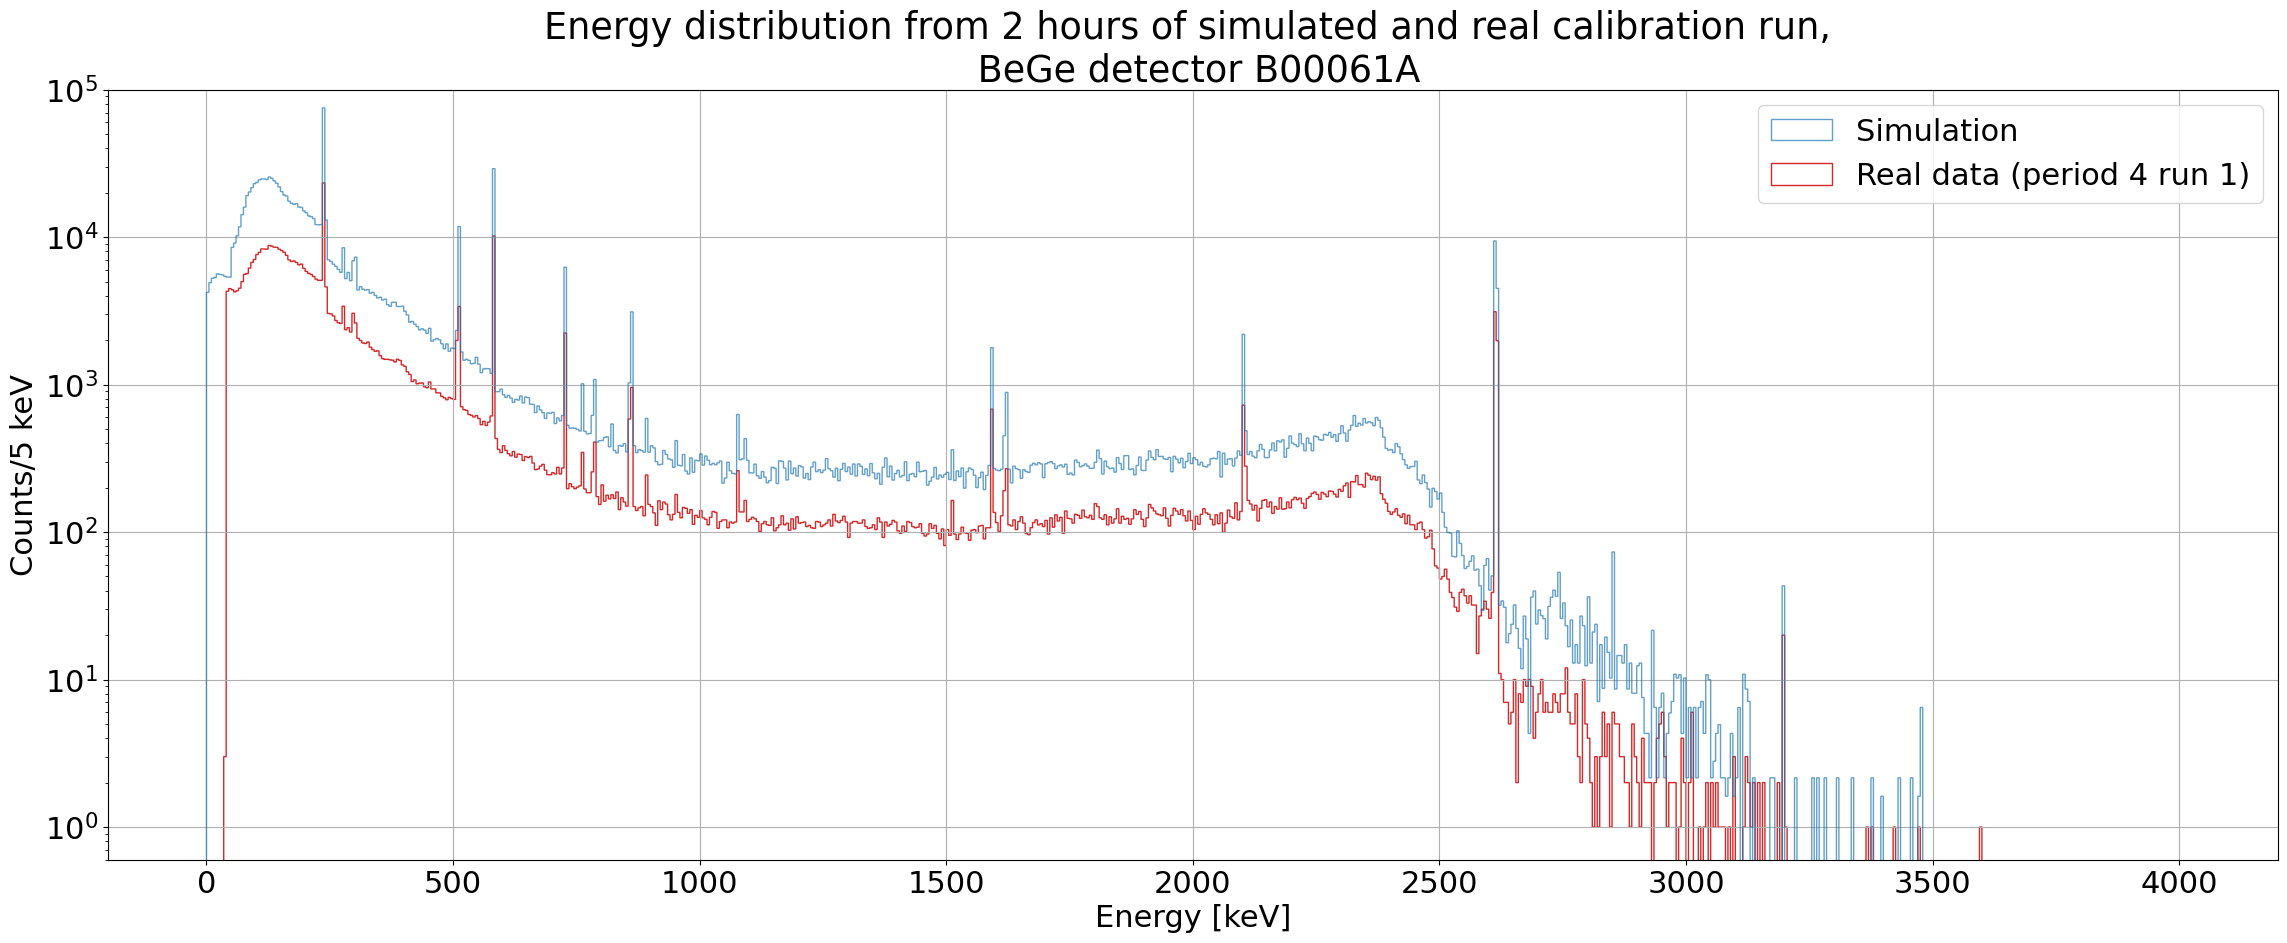

In [27]:
_, ax = plt.subplots()
hist_sim = ax.hist(bins[:-1], bins, weights=counts_sim, label='Simulation', range=[0, 4000], color='C2', alpha=0.7, histtype='step', zorder=5)
hist_data = ax.hist(data_no_pulser_clean.zacEmax_cal, bins=800, label='Real data (period 4 run 1)', range=[0, 4000], color='C3', histtype='step', zorder=0)
plt.legend()
plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel('Counts/5 keV')
plt.title('Energy distribution from 2 hours of simulated and real calibration run, \n BeGe detector B00061A')
plt.ylim(0.6, 1E5)
#plt.xlim(2700, 3300)
plt.grid()
plt.savefig('sim_vs_real_cal_spectra_bege_5M_29_october.png', bbox_inches='tight')
plt.show()

In [61]:
my_file = open("real_data_all_detectors_BEGE_29_october.txt", "w")
for i in range (len(data_no_pulser_clean.zacEmax_cal)):
    my_file.write(str(data_no_pulser_clean.zacEmax_cal[i]) + "\n")
    #print(str(bins[i]) + "\t" + str(hist_data[0][i]))
my_file.close()

### ICPC ###

In [28]:
data = []
pht_data = lh5.read_as(
    'ch1116802/hit',
    files[0][0][0:29],
    library="ak" #data should be read into the awkward array format 
)

data.append(pht_data.zacEmax_cal)
data_no_pulser = remove_pulser(files_tcm[0][0][0:29], 1116802, 5, pht_data) #data[0])
data_no_pulser_clean = data_no_pulser[(data_no_pulser.zacEmax_cal < 4000) & (data_no_pulser.zacEmax_cal > 0) & (data_no_pulser.is_valid_cal == 1)]

In [30]:
#Correcting the scaling time removing the time corresponded to the events filtered out
time = 120*60
scaling_time = time-((len(data[0])-len(data_no_pulser_clean))*130E-6)
print("Raw_time = " + str(time))
print("Scaling_time = " + str(scaling_time))
time = scaling_time

Raw_time = 7200
Scaling_time = 7188.14049


In [31]:
counts_sim = np.zeros(shape=800)
k = 0
sum_data_sim = 0
for i in range(1,4):
    for j in range(1,5):
        data_sim = open_file(f"file_output_energies/file_output_energies_icpc_5M/simulation_data_source_{i}_{j}.txt")
        counts, bins = rescaling_histo(data_sim, activities[k], time, 800)
        sum_data_sim += len(data_sim)
        counts_sim += counts
        print(activities[k])
        k += 1

2819.211918908965
1123.5512489119956
1498.527343305105
1940.8452450699758
2709.641060672329
775.9829681379939
1785.9168107470682
2099.3732952846835
2733.4492583996366
939.8862836944835
1168.9088249982672
2479.27772284509


In [33]:
counts_sim = counts_sim/5E6

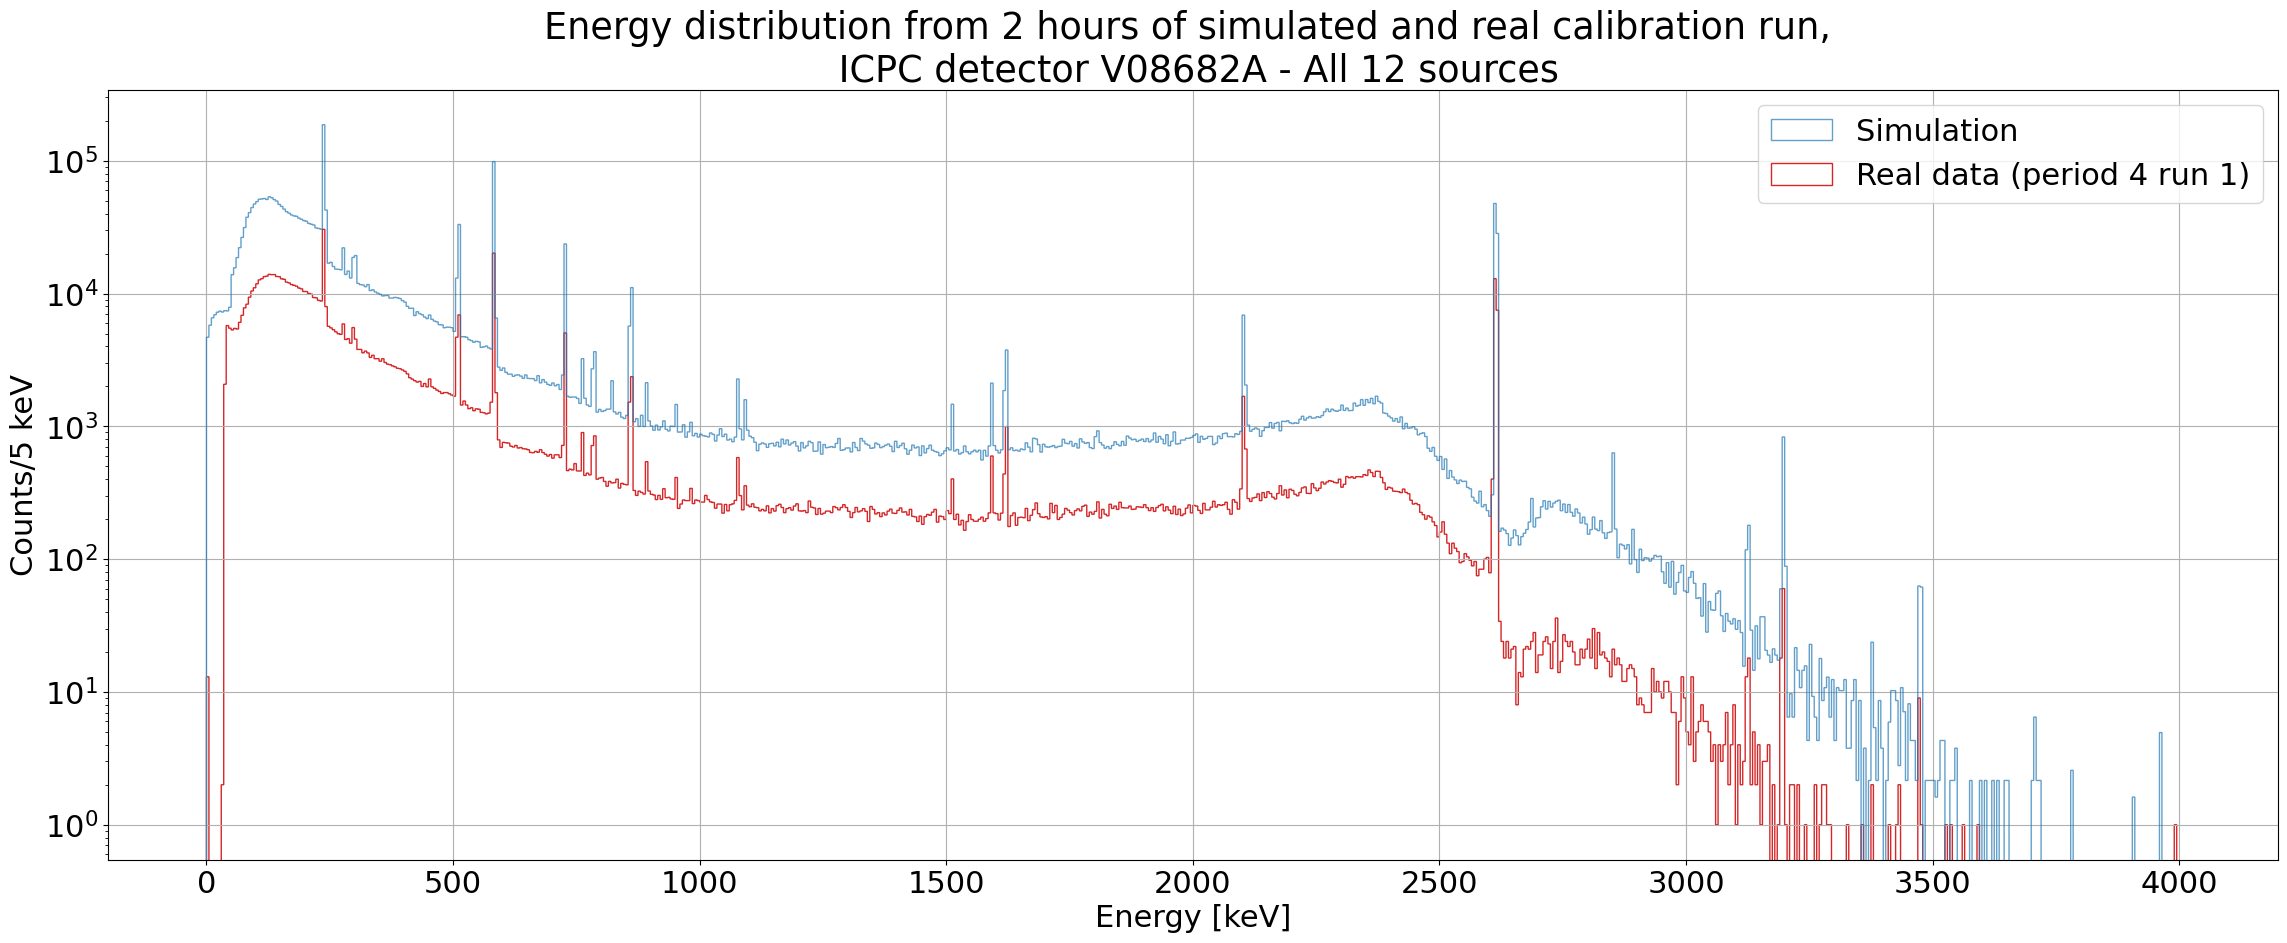

In [34]:
_, ax = plt.subplots()
#ax.hist(all_data.trapEmax, bins=500, label='trap', color='C1')
hist_sim = ax.hist(bins[:-1], bins, weights=counts_sim, label='Simulation', range=[0, 4000], color='C2', alpha=0.7, histtype='step', zorder=10)
hist_data = ax.hist(data_no_pulser_clean.zacEmax_cal, bins=800, label='Real data (period 4 run 1)', range=[0, 4000], color='C3', histtype='step', zorder=0)
plt.legend()
plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel('Counts/5 keV')
plt.title('Energy distribution from 2 hours of simulated and real calibration run, \n ICPC detector V08682A - All 12 sources')
plt.grid()
plt.savefig('sim_vs_real_cal_spectra_icpc_5M_29_october.png', bbox_inches='tight')
plt.show()

In [69]:
my_file = open("real_data_all_detectors_ICPC_29_october.txt", "w")
for i in range (len(data_no_pulser_clean.zacEmax_cal)):
    my_file.write(str(data_no_pulser_clean.zacEmax_cal[i]) + "\n")
    #print(str(bins[i]) + "\t" + str(hist_data[0][i]))
my_file.close()

### PPC ###

In [35]:
data = []
pht_data = lh5.read_as(
    'ch1081601/hit',
    files[0][0][0:29],
    library="ak" #data should be read into the awkward array format 
)

data.append(pht_data.zacEmax_cal)
data_no_pulser = remove_pulser(files_tcm[0][0][0:29], 1081601, 5, pht_data) #data[0])
data_no_pulser_clean = data_no_pulser[(data_no_pulser.zacEmax_cal < 4000) & (data_no_pulser.zacEmax_cal > 0) & (data_no_pulser.is_valid_cal == 1)]

In [36]:
#Correcting the scaling time removing the time corresponded to the events filtered out
time = 120*60
scaling_time = time-((len(data[0])-len(data_no_pulser_clean))*130E-6)
print("Raw_time = " + str(time))
print("Scaling_time = " + str(scaling_time))
time = scaling_time

Raw_time = 7200
Scaling_time = 7198.78021


In [37]:
counts_sim = np.zeros(shape=800)
k = 0
sum_data_sim = 0
for i in range(1,4):
    for j in range(1,5):
        data_sim = open_file(f"file_output_energies/file_output_energies_ppc_5M/simulation_data_source_{i}_{j}.txt")
        counts, bins = rescaling_histo(data_sim, activities[k], time, 800)
        sum_data_sim += len(data_sim)
        counts_sim += counts
        print(activities[k])
        k += 1

2819.211918908965
1123.5512489119956
1498.527343305105
1940.8452450699758
2709.641060672329
775.9829681379939
1785.9168107470682
2099.3732952846835
2733.4492583996366
939.8862836944835
1168.9088249982672
2479.27772284509


In [38]:
counts_sim = counts_sim/5E6 #*sum_data_sim/sum_data_sim_tot

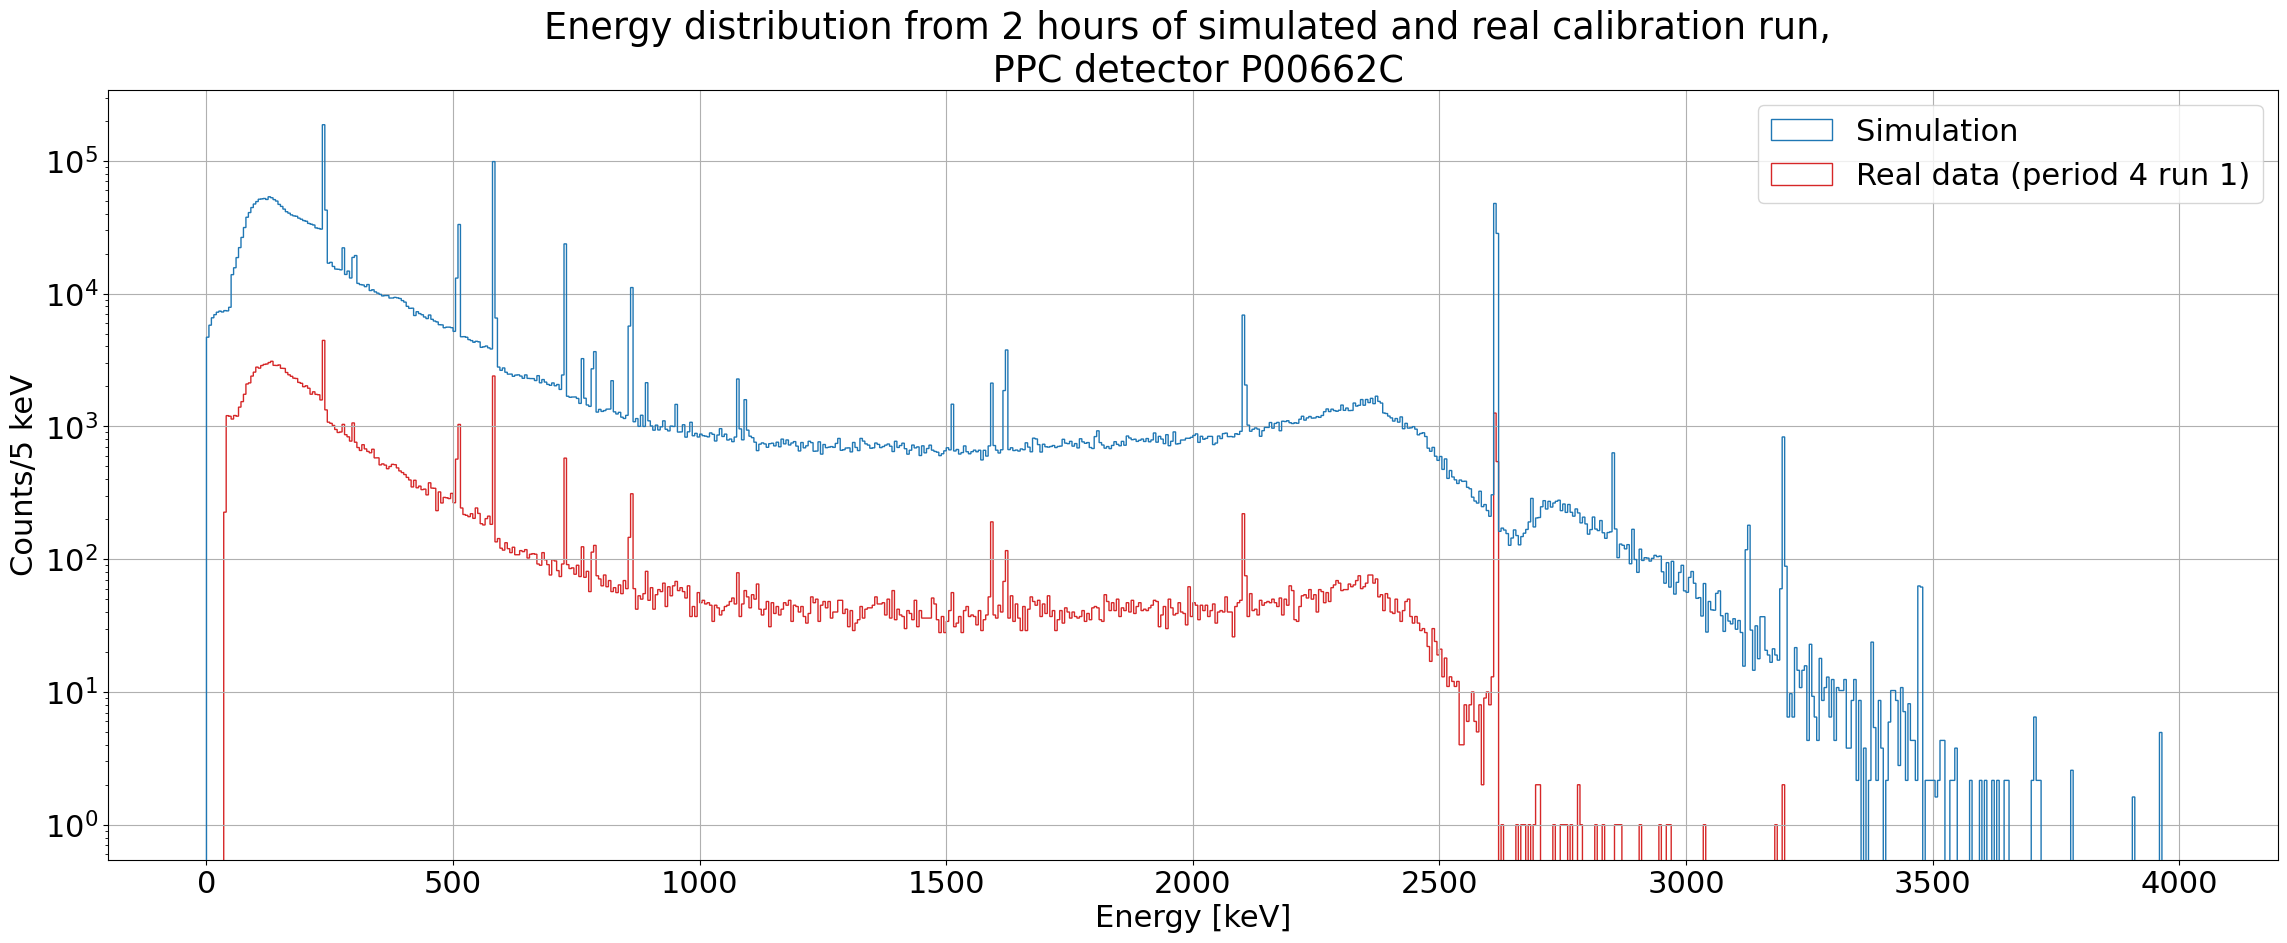

In [42]:
_, ax = plt.subplots()
#ax.hist(all_data.trapEmax, bins=500, label='trap', color='C1')
hist_sim = ax.hist(bins[:-1], bins, weights=counts_sim, label='Simulation', range=[0, 4000], color='C2', histtype='step', zorder=10)
hist_data = ax.hist(data_no_pulser_clean.zacEmax_cal, bins=800, label='Real data (period 4 run 1)', range=[0, 4000], color='C3', histtype='step', zorder=0)
plt.legend()
plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel('Counts/5 keV')
plt.title('Energy distribution from 2 hours of simulated and real calibration run, \n PPC detector P00662C')
plt.grid()
plt.savefig('sim_vs_real_cal_spectra_ppc_29_october.png', bbox_inches='tight')
plt.show()

In [43]:
my_file = open("real_data_all_detectors_PPC_29_october.txt", "w")
for i in range (len(data_no_pulser_clean.zacEmax_cal)):
    my_file.write(str(data_no_pulser_clean.zacEmax_cal[i]) + "\n")
    #print(str(bins[i]) + "\t" + str(hist_data[0][i]))
my_file.close()

### Coax ###

In [44]:
data = []
pht_data = lh5.read_as(
    'ch1120005/hit',
    files[0][0][0:29],
    library="ak" #data should be read into the awkward array format 
)

data.append(pht_data.zacEmax_cal)
data_no_pulser = remove_pulser(files_tcm[0][0][0:29], 1120005, 5, pht_data) #data[0])
data_no_pulser_clean = data_no_pulser[(data_no_pulser.zacEmax_cal < 4000) & (data_no_pulser.zacEmax_cal > 0) & (data_no_pulser.is_valid_cal == 1)]

In [45]:
#Correcting the scaling time removing the time corresponded to the events filtered out
time = 120*60
scaling_time = time-((len(data[0])-len(data_no_pulser_clean))*130E-6)
print("Raw_time = " + str(time))
print("Scaling_time = " + str(scaling_time))
time = scaling_time

Raw_time = 7200
Scaling_time = 7198.18793


In [46]:
counts_sim = np.zeros(shape=800)
k = 0 
sum_data_sim = 0
for i in range(1,4):
    for j in range(1,5):
        data_sim = open_file(f"file_output_energies/file_output_energies_coax_5M/simulation_data_source_{i}_{j}.txt")
        counts, bins = rescaling_histo(data_sim, activities[k], time, 800)
        sum_data_sim += len(data_sim)
        counts_sim += counts
        print(activities[k])
        k += 1

2819.211918908965
1123.5512489119956
1498.527343305105
1940.8452450699758
2709.641060672329
775.9829681379939
1785.9168107470682
2099.3732952846835
2733.4492583996366
939.8862836944835
1168.9088249982672
2479.27772284509


In [47]:
#counts_sim = counts_sim*sum_data_sim/sum_data_sim_tot
counts_sim = counts_sim/5E6

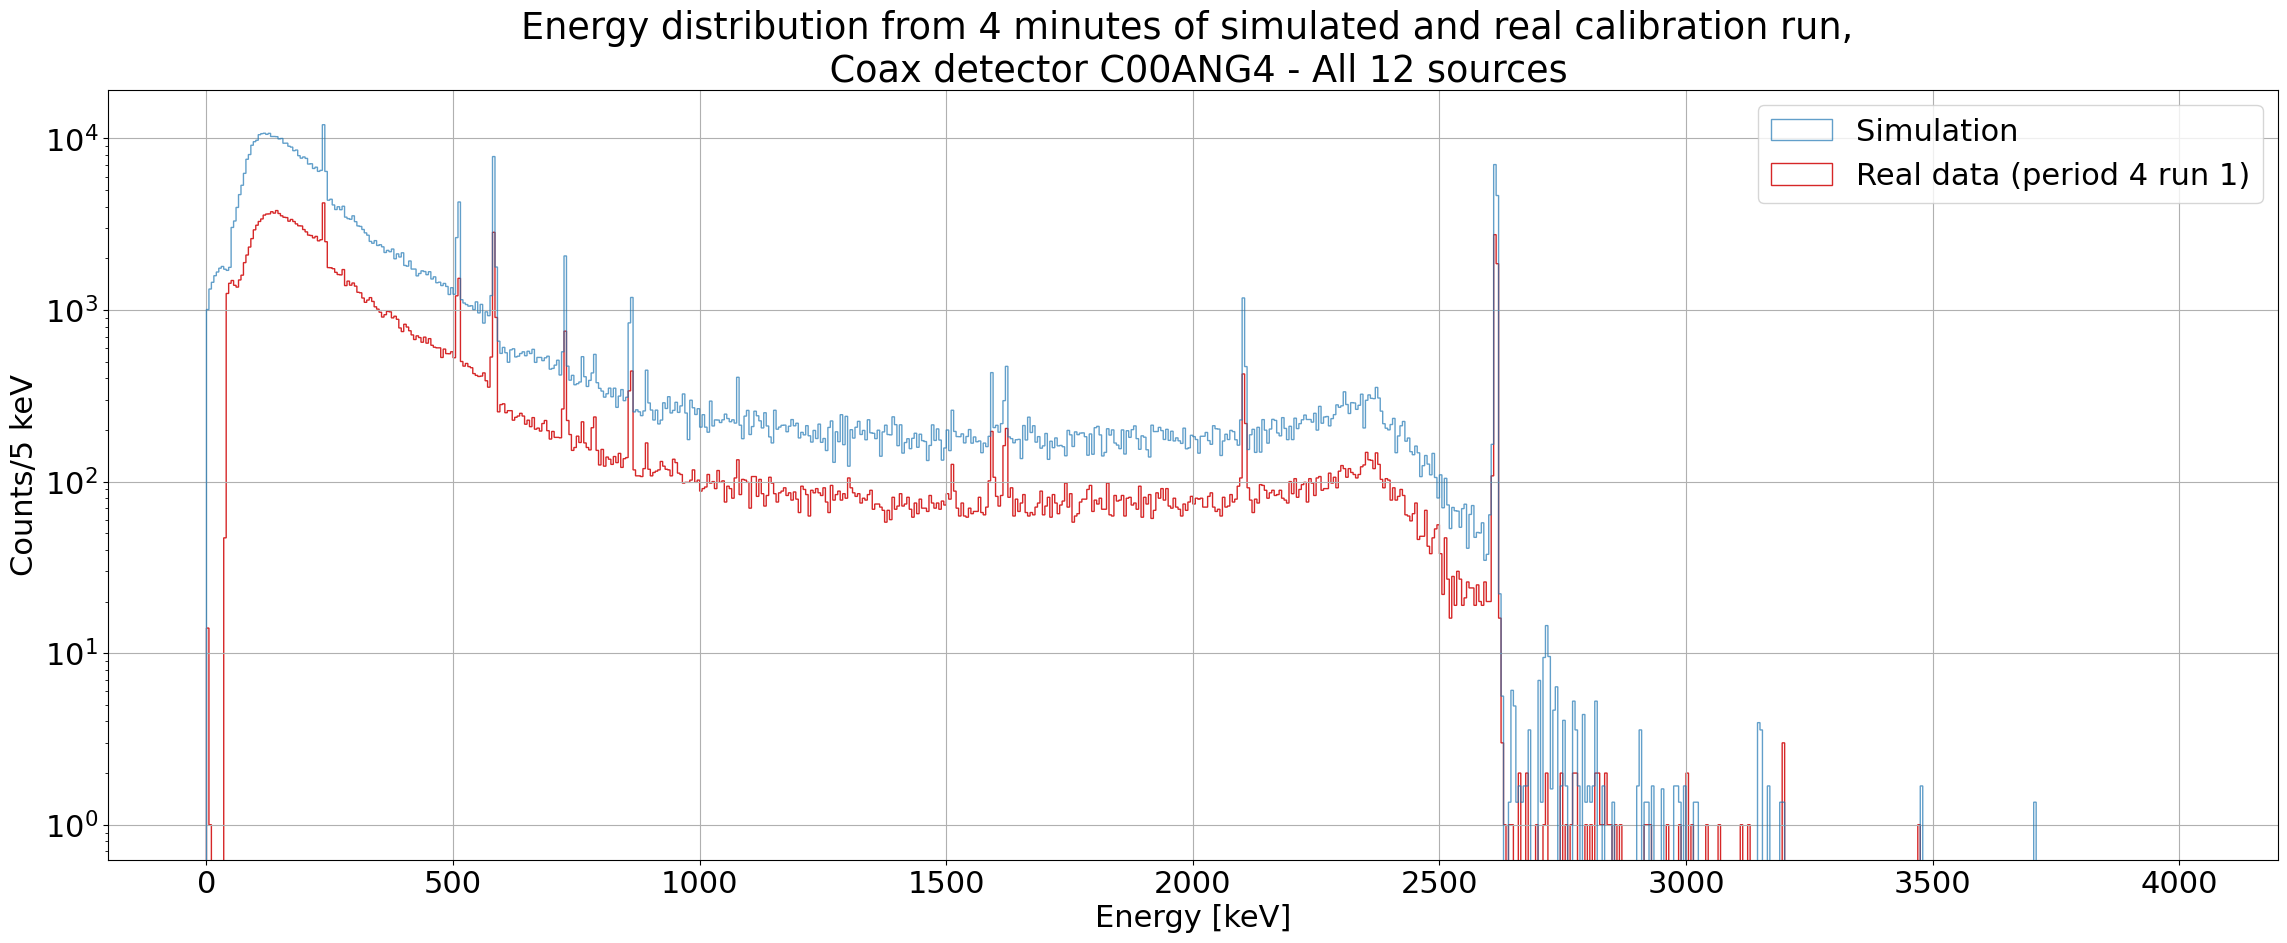

In [49]:
_, ax = plt.subplots()
#ax.hist(all_data.trapEmax, bins=500, label='trap', color='C1')
hist_sim = ax.hist(bins[:-1], bins, weights=counts_sim, label='Simulation', range=[0, 4000], color='C2', alpha=0.7, histtype='step', zorder=10)
hist_data = ax.hist(data_no_pulser_clean.zacEmax_cal, bins=800, label='Real data (period 4 run 1)', range=[0, 4000], color='C3', histtype='step', zorder=0)
plt.legend()
plt.yscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel('Counts/5 keV')
plt.title('Energy distribution from 4 minutes of simulated and real calibration run, \n Coax detector C00ANG4 - All 12 sources')
plt.grid()
plt.savefig('sim_vs_real_cal_spectra_coax_29_october.png', bbox_inches='tight')
plt.show()

In [50]:
my_file = open("real_data_all_detectors_COAX_29_october.txt", "w")
for i in range (len(data_no_pulser_clean.zacEmax_cal)):
    my_file.write(str(data_no_pulser_clean.zacEmax_cal[i]) + "\n")
    #print(str(bins[i]) + "\t" + str(hist_data[0][i]))
my_file.close()